# TP6 - Clasificador de imágenes con red convolucional

El Notebook incluye código de ejemplo para definir y entrenar una red convolucional con el dataset MNIST. Recuerda que esta parte del trabajo se debe realizar con el dataset CIFAR 10.

Imports necesarios para ejecutar el trabajo

In [1]:
import keras
from keras.datasets import mnist
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping
import time
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import backend as K
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

In [2]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()

Carga del dataset MNIST

Importante observar como la organización de los datos es diferente que en el caso del perceptrón para poder aplicar bien las convoluciones

In [3]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.np_utils.to_categorical(y_test,  num_classes)

11501568/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [4]:
# Definicion de la red convolucional
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

Preguntas a responder de la celda anterior:

**1.    Incluye un dibujo de la arquitectura de la red programada en la celda anterior.**



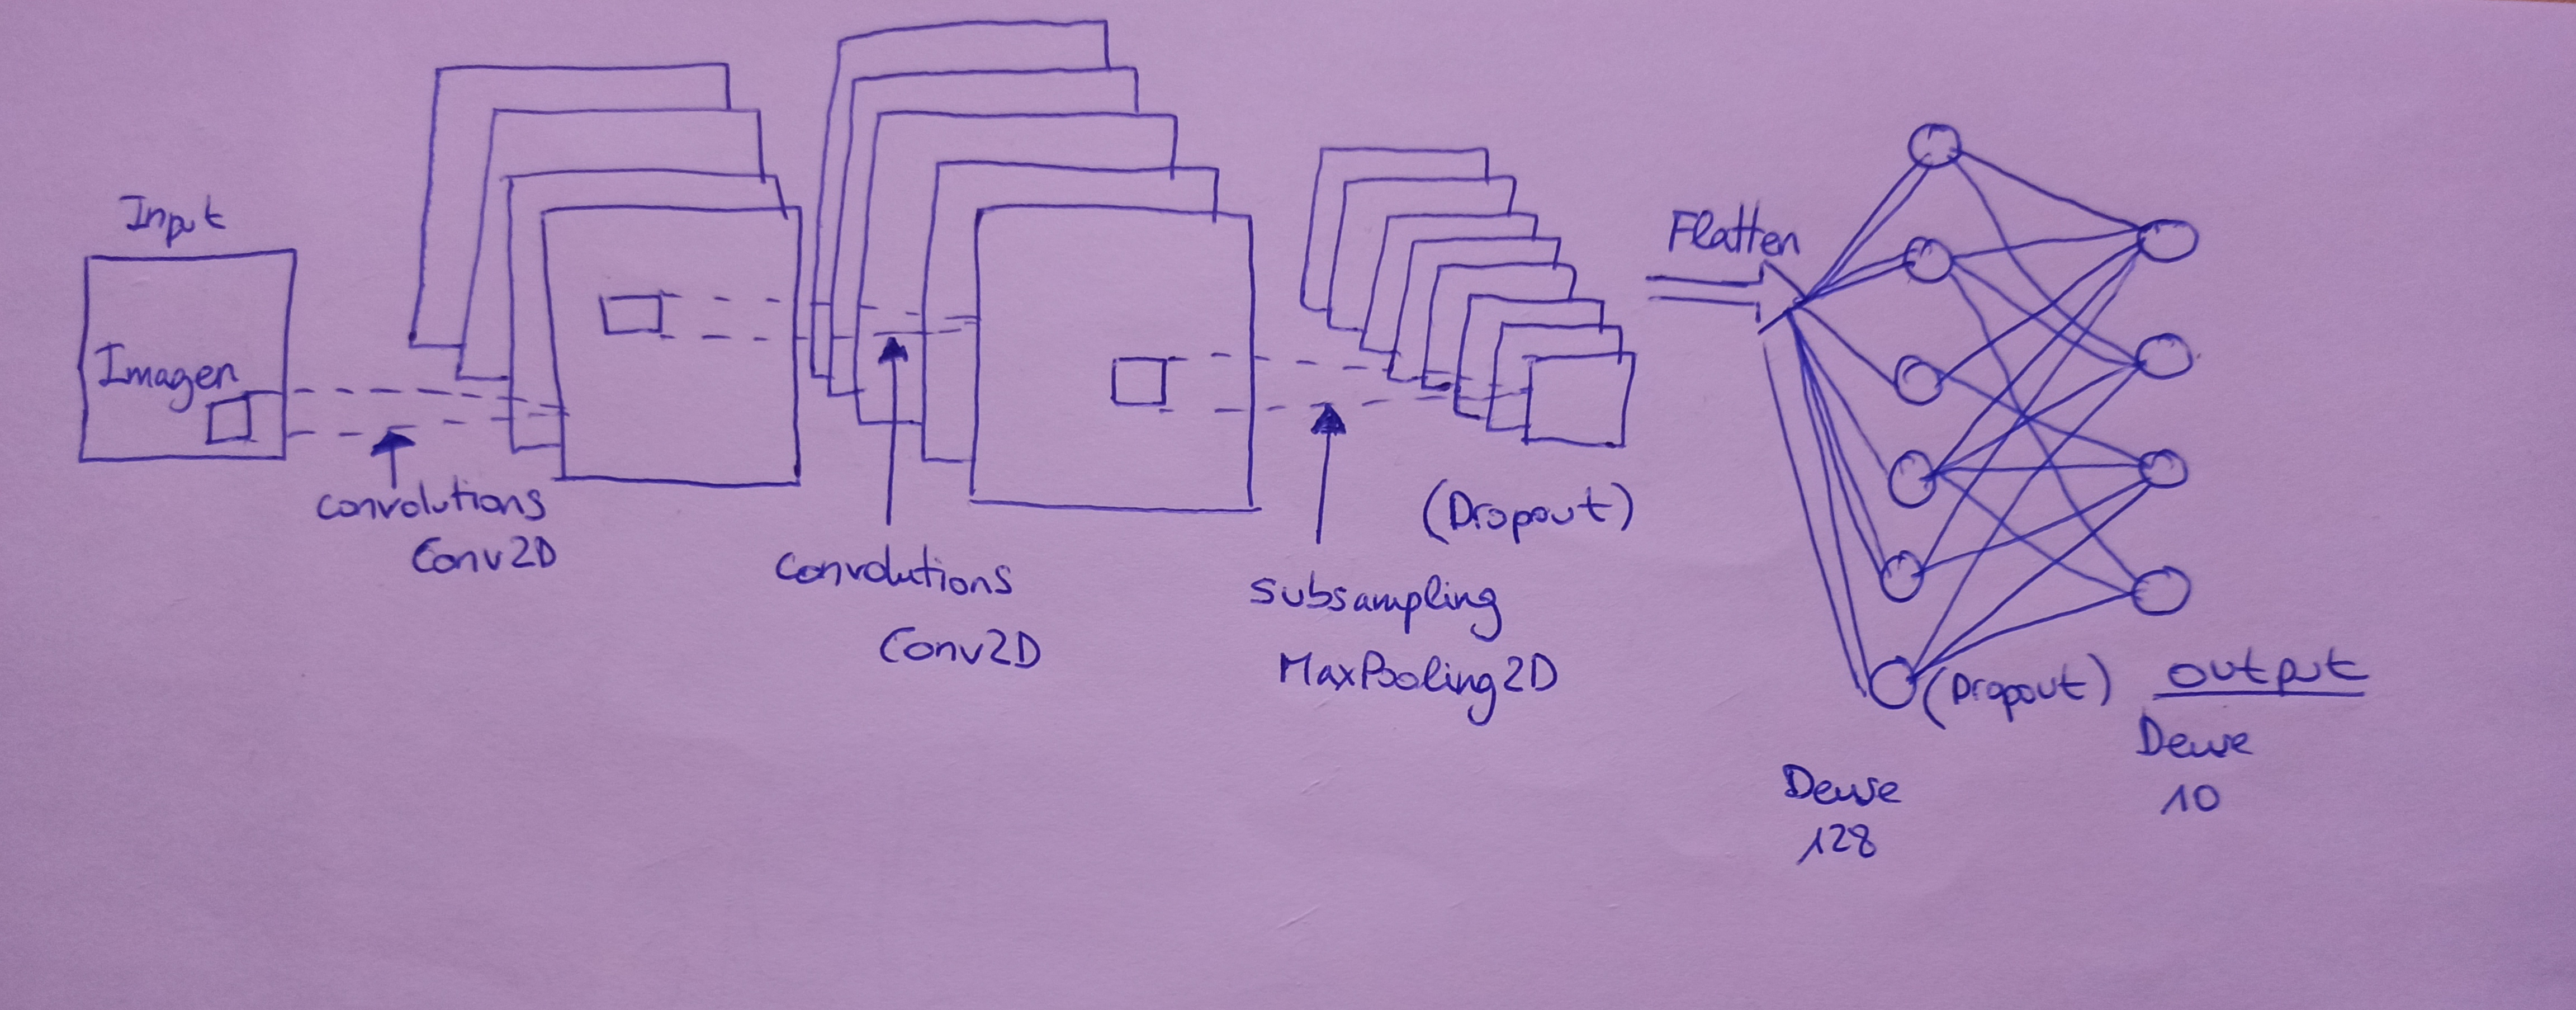

**2.    Explica brevemente qué hace cada capa de la red.**

Las dos primeras capas *Conv2D* crean un núcleo de convolución que se convoluciona con la entrada de la capa para producir un tensor de salidas.
Consisten en tomar “grupos de pixeles cercanos” de la imagen de entrada e ir operando matemáticamente (producto escalar) contra una pequeña matriz que se llama kernel. Ese kernel supongamos de tamaño 3×3 pixels “recorre” todas las neuronas de entrada (de izquierda-derecha, de arriba-abajo) y genera una nueva matriz de salida, que en definitiva será nuestra nueva capa de neuronas ocultas.

*MaxPooling2D* realiza una operación de agrupación máxima para datos espaciales 2D. Reduce la muestra de la entrada a lo largo de sus dimensiones espaciales (alto y ancho) tomando el valor máximo sobre una ventana de entrada (de tamaño definido por pool_size) para cada canal de la entrada. Es decir lo que hace es reducir la cantidad de neuronas.

*Dropout* apaga un porcentaje de neuronas aleatorio.

*Flatten* aplana la entrada para poder aplicar después las capas *Dense*.

La primrea capa *Dense* es una capa oculta (con función de activación ReLu) y la segunda es la capa de salida.


Epoch 1/12
469/469 [==============================] - 134s 284ms/step - loss: 0.2576 - accuracy: 0.9226
Epoch 2/12
469/469 [==============================] - 134s 285ms/step - loss: 0.0885 - accuracy: 0.9737
Epoch 3/12
469/469 [==============================] - 134s 286ms/step - loss: 0.0664 - accuracy: 0.9802
Epoch 4/12
469/469 [==============================] - 134s 286ms/step - loss: 0.0545 - accuracy: 0.9832
Epoch 5/12
469/469 [==============================] - 133s 284ms/step - loss: 0.0466 - accuracy: 0.9851
Epoch 6/12
469/469 [==============================] - 134s 285ms/step - loss: 0.0408 - accuracy: 0.9870
Epoch 7/12
469/469 [==============================] - 134s 287ms/step - loss: 0.0354 - accuracy: 0.9892
Epoch 8/12
469/469 [==============================] - 133s 283ms/step - loss: 0.0342 - accuracy: 0.9891
Epoch 9/12
469/469 [==============================] - 132s 282ms/step - loss: 0.0283 - accuracy: 0.9908
Epoch 10/12
469/469 [==============================] - 132s 281m

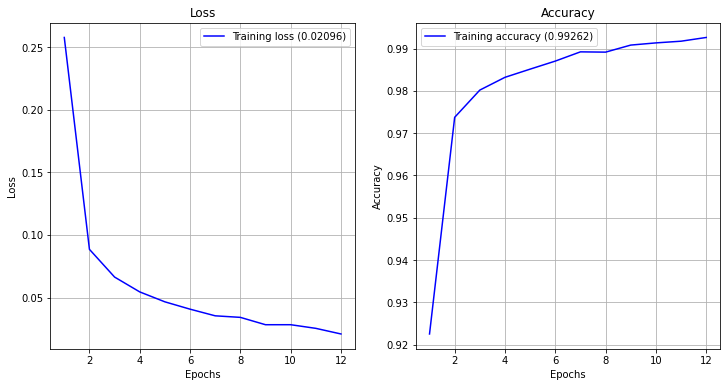

In [5]:
# Ajuste de los parámetros de la red
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True)
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history)

Preguntas a responder de la celda anterior

**¿Qué diferencias observas en el entrenamiento y en los resultados en comparación con las redes diseñadas en el otro Notebook?**

El entrenamiento ha sido mucho más lento que en el caso de los perceptrones.

Loss tanto en training como en test, tienen valores mucho más pequeños. Mientras que en los perceptrones training loss comenzaba siempre alrededor de 0.6 - 0.7 y bajaba hasta 0.1-0.2, en este caso comienza aproximadamente en 0.2 - 0.3 y baja hasta 0.02.

Accurary tienen valores más altos. En training se observa además se comienza con valores mayores, ya que en perceptrón podía comenzar alrededor del 0.8, y aquí alrededor del 0.9. 

-

El notebook que entregues deberá incluir:

1.   Modifica la carga de datos, y la configuración inicial de la red si lo ves necesario, para que cargue/utilice el dataset CIFAR10 en lugar de MNIST. Puedes pasar a blanco y negro las imágenes, o hacer que la red trabaje con imagenes en color (n x m x 3), y siempre, normalizar los valores (atributos con valores entre 0 y 1).
2.   Entrena un perceptrón multi-capa y evalúa los resultados que obtiene para CIFAR10. Compara estos resultados con los obtenidos en el dataset anterior (MNIST)
3.   Entrena una red convolucional y evalúa los resultados que obtiene con CIFAR10. Compara estos resultados con los obtenidos para el perceptrón.
4.   Opcional: Repite el último paso, entrenar la red convolucional, utilizando el dataset CIFAR 100, con 100 clases diferentes. En este caso, recuerda asegurarte que el Colab está utilizando una configuración con GPU.

**1.   Modifica la carga de datos, y la configuración inicial de la red para que cargue/utilice el dataset CIFAR10 en lugar de MNIST.**

In [10]:
batch_size = 128
num_classes = 10
epochs = 12

# input image dimensions
img_rows, img_cols = 32, 32
num_pixels = img_rows * img_cols

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)

# convert from integers to floats
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# normalize to range 0-1
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.np_utils.to_categorical(y_test,  num_classes)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


**2.   Entrena un perceptrón multi-capa y evalúa los resultados que obtiene para CIFAR10. Compara estos resultados con los obtenidos en el dataset anterior (MNIST)**

In [11]:
# Función para parar cuando ya no mejora el error en los datos de validacion
earlystop=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 3072)              0         
                                                                 
 dense_14 (Dense)            (None, 100)               307300    
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_15 (Dense)            (None, 50)                5050      
                                                                 
 dropout_11 (Dropout)        (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 10)                510       
                                                                 
Total params: 312,860
Trainable params: 312,860
Non-tr

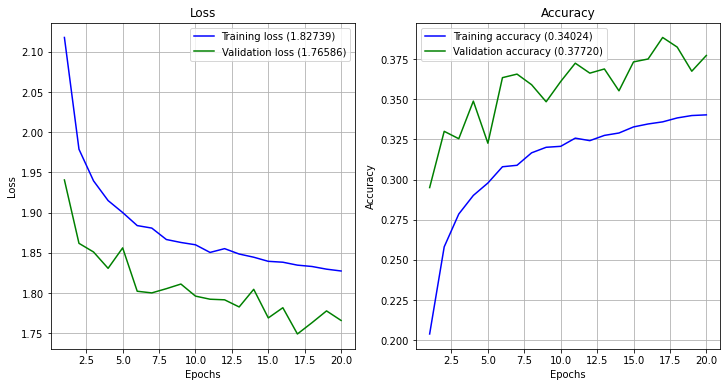

Accuracy train:  38.77%
Accuracy test:   38.11%


In [15]:
#Definir red multi-capa
verbose = True
model_3 = Sequential()
#Aplana la entrada
model_3.add(Flatten(input_shape=(32, 32, 3)))
model_3.add(Dense(100, activation='relu', input_shape=(32, 32, 3)))
model_3.add(Dropout(0.2))
model_3.add(Dense(50, activation='relu', input_shape=(32, 32, 3)))
model_3.add(Dropout(0.2))
model_3.add(Dense(10, activation='sigmoid'))
model_3.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
model_3.summary()

#Gráficas
t0 = time.perf_counter()
history_3 = model_3.fit(x_train, y_train,
                    batch_size=128,
                    epochs=20,
                    validation_split=0.1,
                    callbacks=[earlystop],
                    verbose=verbose)

train_time_3 = time.perf_counter() - t0
print('%s %.3f%s' %  ('Training time: ', train_time_3, 's') )
plot_history(history_3)

# Evaluar la red
train_score_3 = model_3.evaluate(x_train, y_train, verbose=0)
test_score_3 = model_3.evaluate(x_test, y_test, verbose=0)
print('%s %2.2f%s' % ('Accuracy train: ', 100*train_score_3[1], '%' ))
print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score_3[1], '%'))

Se observa como los valores son muchísimo peores que para MNIST. Tanto en las gráficas como los valores finales. No llega ni a la mitad de accuracy train ni test de lo que alcanzaban los perceptrones de MNIST

**3.   Entrena una red convolucional y evalúa los resultados que obtiene con CIFAR10. Compara estos resultados con los obtenidos para el perceptrón.**

In [16]:
# Definicion de la red convolucional
model_1 = Sequential()
model_1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_1.add(Conv2D(64, (3, 3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2, 2)))
model_1.add(Dropout(0.25))
model_1.add(Flatten())
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(num_classes, activation='softmax'))
model_1.compile(loss=keras.losses.categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 12544)             0         
                                                                 
 dense_17 (Dense)            (None, 128)               1605760   
                                                      

Epoch 1/12
391/391 [==============================] - 154s 392ms/step - loss: 1.6370 - accuracy: 0.4084
Epoch 2/12
391/391 [==============================] - 153s 390ms/step - loss: 1.2812 - accuracy: 0.5466
Epoch 3/12
391/391 [==============================] - 151s 385ms/step - loss: 1.1515 - accuracy: 0.5965
Epoch 4/12
391/391 [==============================] - 151s 385ms/step - loss: 1.0719 - accuracy: 0.6229
Epoch 5/12
391/391 [==============================] - 150s 384ms/step - loss: 1.0041 - accuracy: 0.6472
Epoch 6/12
391/391 [==============================] - 151s 385ms/step - loss: 0.9551 - accuracy: 0.6640
Epoch 7/12
391/391 [==============================] - 150s 383ms/step - loss: 0.9138 - accuracy: 0.6768
Epoch 8/12
391/391 [==============================] - 150s 385ms/step - loss: 0.8645 - accuracy: 0.6942
Epoch 9/12
391/391 [==============================] - 150s 384ms/step - loss: 0.8287 - accuracy: 0.7041
Epoch 10/12
391/391 [==============================] - 150s 383m

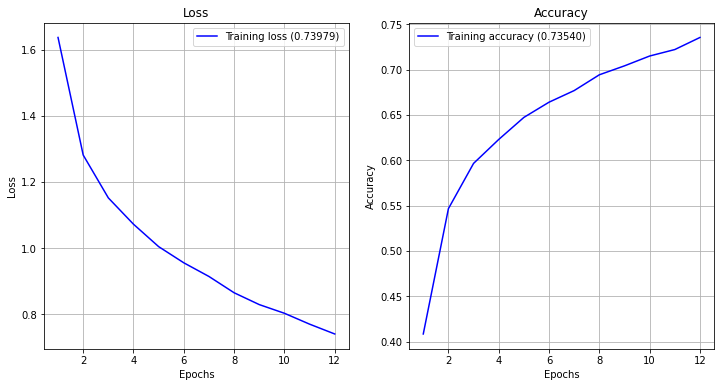

In [17]:
# Ajuste de los parámetros de la red
history_1 = model_1.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=True)
score = model_1.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plot_history(history_1)

Se observa como en este caso da mejores resultados de accuracy. Un 70% frente a un 38%.
En caso de Loss se observa como comienza con valores mucho más elevados y progresa disminuyendo, pero quedando de igual manera con valores más altos que el perceptrón. 

Las curvas se observa que son mucho más "relajadas", la progresión se hace de manera más suave.